In [1]:
# !pip install spotipy
# !pip install requests
# !pip install nltk


In [2]:
import re
import os
import spotipy
import requests
from spotipy.oauth2 import SpotifyClientCredentials
from bs4 import BeautifulSoup
import pandas as pd
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

In [4]:
class GetLyrics():
    
    def __init__(self, spotify_client_id, spotify_client_secret, user_id, playlist_id, genius_key):
        self.spotify_client_id = os.getenv('SPOTIFY_CLIENT_ID')
        self.spotify_client_secret = os.getenv('SPOTIFY_CLIENT_SECRET')
        self.user_id = os.getenv('SPOTIFY_USER_ID')
        self.playlist_id = '5qU5rlfMhe9zfDLJgwemZk'
        self.genius_key = os.getenv('GENIUS_KEY') #we plugin personal spotfiy and genius credentials and playlist id
        
    def get_playlist_info(self):
        token = SpotifyClientCredentials(client_id=self.spotify_client_id,
                                         client_secret=self.spotify_client_secret).get_access_token()
        sp = spotipy.Spotify(token)
        playlist = sp.user_playlist_tracks(self.user_id, self.playlist_id)
        self.playlist = playlist
        return self.playlist
    
    def get_track_names(self):
        track_names = []
        for song in range(len(self.playlist['items'])):
            track_names.append(self.playlist['items'][song]['track']['name'])
        self.track_names = track_names
        return self.track_names
    
    def get_track_artists(self):
        track_artists = []
        for song in range(len(self.playlist['items'])):
            track_artists.append(self.playlist['items'][song]['track']['artists'][0]['name'])
        self.track_artists = track_artists
        return self.track_artists
        
    def request_song_info(self, track_name, track_artist):
        self.track_name = track_name
        self.track_artist = track_artist
        base_url = 'https://api.genius.com'
        headers = {'Authorization': 'Bearer ' + self.genius_key}
        search_url = base_url + '/search'
        data = {'q': track_name + ' ' + track_artist}
        response = requests.get(search_url, data=data, headers=headers)
        self.response = response
        return self.response

    def check_hits(self):
        json = self.response.json()
        remote_song_info = None
        for hit in json['response']['hits']:
            if self.track_artist.lower() in hit['result']['primary_artist']['name'].lower():
                remote_song_info = hit
                break
        self.remote_song_info = remote_song_info
        return self.remote_song_info
    
    def get_url(self):
        song_url = self.remote_song_info['result']['url']
        self.song_url = song_url
        return self.song_url
    
    def scrape_lyrics(self):
        page = requests.get(self.song_url)
        html = BeautifulSoup(page.text, 'html.parser')
        lyrics1 = html.find("div", class_="lyrics")
        lyrics2 = html.find("div", class_="Lyrics__Container-sc-1ynbvzw-2 jgQsqn")
        if lyrics1:
            lyrics = lyrics1.get_text()
        elif lyrics2:
            lyrics = lyrics2.get_text()
        elif lyrics1 == lyrics2 == None:
            lyrics = None
        return lyrics

    def get_lyrics(self):
        playlist = GetLyrics.get_playlist_info(self)
        track_names = GetLyrics.get_track_names(self)
        track_artists = GetLyrics.get_track_artists(self)
        song_lyrics = []
        for i in range(len(self.track_names)):
            print("\n")
            print(f"Working on track {i}.")
            response = GetLyrics.request_song_info(self, self.track_names[i], self.track_artists[i])
            remote_song_info = GetLyrics.check_hits(self)
            if remote_song_info == None:
                lyrics = None
                print(f"Track {i} is not in the Genius database.")
            else:
                url = GetLyrics.get_url(self)
                lyrics = GetLyrics.scrape_lyrics(self)
                if lyrics == None:
                    print(f"Track {i} is not in the Genius database.")
                else:
                    print(f"Retrieved track {i} lyrics!")
            song_lyrics.append(lyrics)
        return song_lyrics

In [5]:
songs = GetLyrics(os.getenv('SPOTIFY_CLIENT_ID'), os.getenv('SPOTIFY_CLIENT_SECRET'), os.getenv('SPOTIFY_USER_ID'), '5qU5rlfMhe9zfDLJgwemZk', os.getenv('GENIUS_KEY'))
song_lyrics = songs.get_lyrics() #this will get this the song lyrics using again credentials 



Working on track 0.
Retrieved track 0 lyrics!


Working on track 1.
Retrieved track 1 lyrics!


Working on track 2.
Retrieved track 2 lyrics!


Working on track 3.
Retrieved track 3 lyrics!


Working on track 4.
Retrieved track 4 lyrics!


Working on track 5.
Retrieved track 5 lyrics!


Working on track 6.
Retrieved track 6 lyrics!


Working on track 7.
Track 7 is not in the Genius database.


Working on track 8.
Track 8 is not in the Genius database.


Working on track 9.
Track 9 is not in the Genius database.


Working on track 10.
Retrieved track 10 lyrics!


Working on track 11.
Retrieved track 11 lyrics!


Working on track 12.
Track 12 is not in the Genius database.


Working on track 13.
Retrieved track 13 lyrics!


Working on track 14.
Retrieved track 14 lyrics!


Working on track 15.
Track 15 is not in the Genius database.


Working on track 16.
Retrieved track 16 lyrics!


Working on track 17.
Track 17 is not in the Genius database.


Working on track 18.
Retrieved track 18 

In [6]:
df = pd.DataFrame()
df['track_name'] = songs.track_names
df['artist'] = songs.track_artists
df['lyrics'] = song_lyrics 

In [7]:
df = df.dropna()
df = df.loc[df['lyrics'] != "[Non-Lyrical Vocals]"]
df = df.loc[df['lyrics'] != '']

In [8]:
df.reset_index(drop=True, inplace=True) #reset the index

In [9]:
song_lyrics = df['lyrics']

In [10]:
for i in range(len(song_lyrics)):
    song_lyrics[i] = re.sub("[\(\[].*?[\)\]]", " ", str(song_lyrics[i]))
    song_lyrics[i] = song_lyrics[i].replace("\n", " ")
    song_lyrics[i] = re.sub(r"(\w)([A-Z])", r"\1 \2", str(song_lyrics[i]))  #we iterate through the rows to delete punctuationan and other unnesary sympols

In [11]:
df

,track_name,artist,lyrics
0,AMERIKA,Rammstein,We're all living in Amerika Amerika ist wund...
1,Dream On,Aerosmith,Every time​ that I look in the mirror All ...
2,Enter Sandman,Metallica,"Say your prayers, little one, don't forget, ..."
3,Spanish Train,Chris de Burgh,There's a Spanish train that runs between ...
4,Whiskey In The Jar,Metallica,As I was going over the Cork and Kerry mou...
5,Iron Man,Black Sabbath,I am Iron Man Has he lost his mind?Can he see...
6,Nothing Else Matters,Metallica,So close no matter how far Couldn't be ...
7,Paranoid,Black Sabbath,Finished with my woman 'cause she couldn't h...
8,Sad But True,Metallica,"Hey , I'm your life, I'm the one who take..."
9,Smells Like Teen Spirit,Nirvana,"Load up on guns, bring your friends It's fun ..."


In [12]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vangelistrikoupis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [13]:
for i in range(len(df)):
    sentiment = sid.polarity_scores(df.loc[i, 'lyrics'])   #we get the polarity score for each row/song and thus iterate
    df.loc[i, 'neg'] = sentiment['neg']
    df.loc[i, 'neu'] = sentiment['neu']
    df.loc[i, 'pos'] = sentiment['pos']
    df.loc[i, 'compound'] = sentiment['compound']

In [14]:
client_credentials_manager = SpotifyClientCredentials(os.getenv('SPOTIFY_CLIENT_ID'), os.getenv('SPOTIFY_CLIENT_SECRET'))
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [15]:
def show_tracks(results, uriArray):
    for i, item in enumerate(results['items']):
        track = item ['track']
        uriArray.append(track['id'])

def getTrackIDs(user, playlist_id):
    ids = []
    results = sp.user_playlist(user, playlist_id)
    tracks = results['tracks']
    show_tracks(tracks, ids)
    while tracks['next']:
        tracks = sp.next(tracks)
        show_tracks(tracks, ids)
    return ids
   # for item in playlist['tracks']['items']:
   #     track = item['track']
   #     ids.append(track['id'])
   # return ids
ids = getTrackIDs(os.getenv('SPOTIFY_USER_ID'), '5qU5rlfMhe9zfDLJgwemZk')

In [16]:
def getTrackFeatures(id):
  meta = sp.track(id)
  features = sp.audio_features(id)
  # meta data from SpotifyClientCredentials
  name = meta['name']
  album = meta['album']['name']
  artist = meta['album']['artists'][0]['name']
  release_date = meta['album']['release_date']
  length = meta['duration_ms']
  popularity = meta['popularity']
  # musical features as provided by spotify
  acousticness = features[0]['acousticness']
  danceability = features[0]['danceability']
  energy = features[0]['energy']
  instrumentalness = features[0]['instrumentalness']
  liveness = features[0]['liveness']
  loudness = features[0]['loudness']
  mode = features[0]['mode']
  
  tempo = features[0]['tempo']
  time_signature = features[0]['time_signature']
  valence = features[0]['valence']
  analysis_url = features[0]['analysis_url'] 
  track = [name, album, artist, release_date, length, popularity, danceability, acousticness, energy, instrumentalness, liveness, loudness, mode, tempo, time_signature, valence, analysis_url]
   
  return track

In [17]:
import time
tracks = []
for i in range(len(ids)):
  time.sleep(.5)
  track = getTrackFeatures(ids[i])
  tracks.append(track)

In [18]:
data = pd.DataFrame(tracks, columns = ['track_name', 'mode', 'a', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode','tempo', 'time_signature', 'valence', 'analysis_url'])

In [19]:
# df.track_name = df.track_name.astype(str)
# data.track_name = data.track_name.astype(str)


In [20]:
merged=pd.merge(data, df, left_on='track_name', right_on='track_name')

In [21]:
merged

,track_name,mode,a,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,...,tempo,time_signature,valence,analysis_url,artist,lyrics,neg,neu,pos,compound
0,AMERIKA,"REISE, REISE",Rammstein,2004-09-27,226760,67,0.608,0.002580,0.885,0.000013,...,125.023,4,0.518,https://api.spotify.com/v1/audio-analysis/1a8J...,Rammstein,We're all living in Amerika Amerika ist wund...,0.042,0.958,0.000,-0.5994
1,Dream On,Aerosmith,Aerosmith,1973-01-05,266960,80,0.307,0.388000,0.433,0.000091,...,160.900,4,0.224,https://api.spotify.com/v1/audio-analysis/5MxN...,Aerosmith,Every time​ that I look in the mirror All ...,0.035,0.715,0.250,0.9951
2,Enter Sandman,Metallica,Metallica,1991-08-12,331266,81,0.577,0.002130,0.828,0.011400,...,123.257,4,0.604,https://api.spotify.com/v1/audio-analysis/5sIC...,Metallica,"Say your prayers, little one, don't forget, ...",0.090,0.699,0.211,0.8737
3,Spanish Train,Missing You - The Collection,Chris de Burgh,2004-01-01,298093,18,0.398,0.077700,0.542,0.000000,...,94.020,4,0.197,https://api.spotify.com/v1/audio-analysis/7Lr3...,Chris de Burgh,There's a Spanish train that runs between ...,0.150,0.759,0.091,-0.9945
4,Whiskey In The Jar,Garage Inc.,Metallica,1998-01-01,304693,74,0.511,0.000006,0.970,0.001360,...,132.986,4,0.566,https://api.spotify.com/v1/audio-analysis/2R6U...,Metallica,As I was going over the Cork and Kerry mou...,0.065,0.745,0.190,0.9885
5,Iron Man,Paranoid (2009 Remastered Version),Black Sabbath,1970-09-18,354773,73,0.332,0.003670,0.769,0.004130,...,157.378,4,0.525,https://api.spotify.com/v1/audio-analysis/0TI8...,Black Sabbath,I am Iron Man Has he lost his mind?Can he see...,0.026,0.852,0.122,0.8611
6,Nothing Else Matters,Metallica,Metallica,1991-08-12,388266,81,0.553,0.045800,0.362,0.000006,...,142.352,3,0.158,https://api.spotify.com/v1/audio-analysis/0nLi...,Metallica,So close no matter how far Couldn't be ...,0.174,0.764,0.061,-0.9579
7,Paranoid,Paranoid (2009 Remastered Version),Black Sabbath,1970-09-18,168440,79,0.429,0.000078,0.631,0.004110,...,162.734,4,0.376,https://api.spotify.com/v1/audio-analysis/1jzD...,Black Sabbath,Finished with my woman 'cause she couldn't h...,0.166,0.632,0.202,0.8365
8,Sad But True,Metallica,Metallica,1991-08-12,323933,71,0.633,0.000819,0.846,0.001390,...,89.230,4,0.448,https://api.spotify.com/v1/audio-analysis/1PhL...,Metallica,"Hey , I'm your life, I'm the one who take...",0.245,0.531,0.224,-0.9470
9,Smells Like Teen Spirit,Nevermind (Deluxe Edition),Nirvana,1991-09-26,301920,84,0.502,0.000025,0.912,0.000173,...,116.761,4,0.720,https://api.spotify.com/v1/audio-analysis/1f3y...,Nirvana,"Load up on guns, bring your friends It's fun ...",0.206,0.582,0.212,0.5951


In [22]:
import matplotlib.pyplot as plt

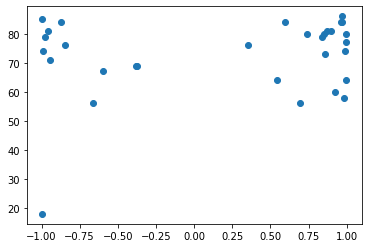

In [23]:
x = merged["popularity"]
y = merged["compound"]
plt.scatter(y,x)